### Time Series Decomposition
##### Decomposition is basically applied in time series analysis, it can also be used as a tool to inform forecasting models on a problem

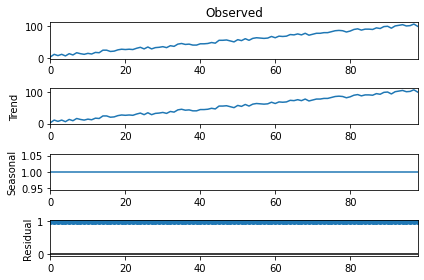

In [1]:
import numpy as np
import pandas as pd
from random import randrange
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
series = [i+randrange(10) for i in range(1,100)]
result = seasonal_decompose(series, model='multiplicative', period=1)
result.plot()
pyplot.show()

### Forecasting fewer outputs with Enc-Dec LSTM

### visualise the data

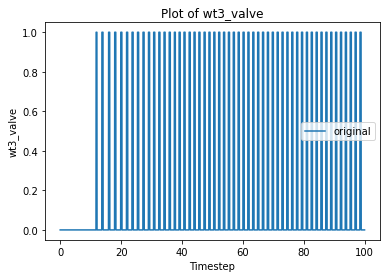

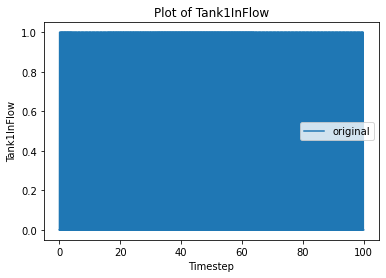

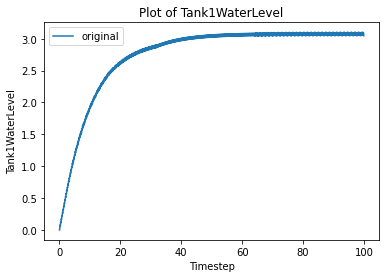

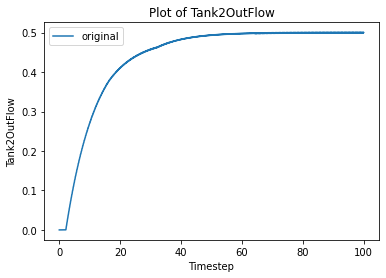

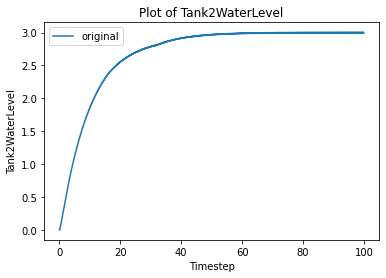

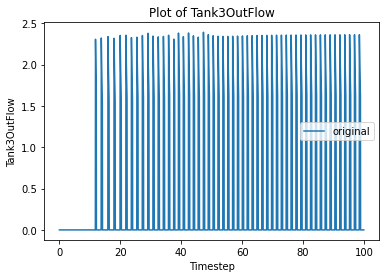

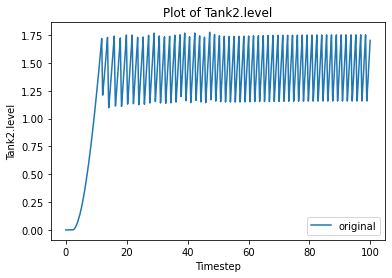

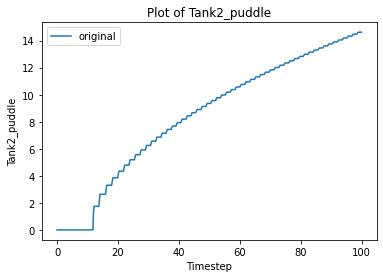

In [46]:
from pandas import read_csv
mydata = read_csv('waterTankNew.csv', header=0, index_col=0)

attr = ["wt3_valve", "Tank1InFlow", "Tank1WaterLevel", "Tank2OutFlow", "Tank2WaterLevel", "Tank3OutFlow", "Tank2.level", "Tank2_puddle"]
for i in range(len(attr)):
    title = "Plot of "+str(attr[i])
    actual = mydata.iloc[:2000,i]
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel(attr[i])
    plt.plot(actual, label="original")
    plt.legend()
    plt.show()

The shape of the raw_data before scaling is (20001, 8)
Epoch 1/100
308/308 [==============================] - 76s 218ms/step - loss: 0.0868
Epoch 2/100
308/308 [==============================] - 69s 223ms/step - loss: 0.0728
Epoch 3/100
308/308 [==============================] - 70s 227ms/step - loss: 0.0727
Epoch 4/100
308/308 [==============================] - 70s 226ms/step - loss: 0.0709
Epoch 5/100
308/308 [==============================] - 70s 228ms/step - loss: 230.1347
Epoch 6/100
308/308 [==============================] - 69s 225ms/step - loss: 0.0720
Epoch 7/100
308/308 [==============================] - 70s 226ms/step - loss: 0.0722
Epoch 8/100
308/308 [==============================] - 69s 223ms/step - loss: 0.0716
Epoch 9/100
308/308 [==============================] - 71s 229ms/step - loss: 0.0720
Epoch 10/100
308/308 [==============================] - 70s 226ms/step - loss: 0.0715
Epoch 11/100
308/308 [==============================] - 69s 225ms/step - loss: 0.0706
Epoch 

308/308 [==============================] - 18s 59ms/step - loss: 0.0340
Epoch 97/100
308/308 [==============================] - 18s 60ms/step - loss: 0.0343
Epoch 98/100
308/308 [==============================] - 18s 59ms/step - loss: 0.0344
Epoch 99/100
308/308 [==============================] - 18s 59ms/step - loss: 0.0350
Epoch 100/100
308/308 [==============================] - 18s 59ms/step - loss: 0.0339
Initial shape of x_input (50, 8)
The shape of yhat after prediction is (1, 100, 8)
The new shape of yhat  is (100, 8)
[[-2.13119984e-02  5.03153086e-01  3.09226632e+00  4.88446295e-01
   3.01629472e+00  1.77580211e-02  1.46343875e+00  3.31033669e+01]
 [-2.26963609e-02  4.67132747e-01  3.14025235e+00  5.11461794e-01
   3.07844186e+00 -2.89264843e-02  1.53133416e+00  3.61970139e+01]
 [-8.62221420e-03  4.86228466e-01  2.97842765e+00  4.98368263e-01
   2.90984988e+00 -3.49334255e-02  1.47819364e+00  3.47655945e+01]
 [ 2.84343362e-02  5.04273713e-01  3.01455712e+00  4.98921454e-01
   2

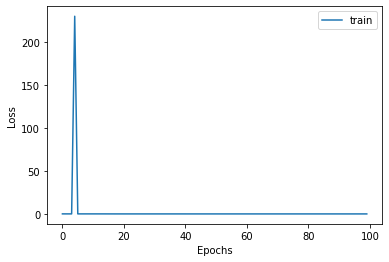

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                11800     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 100, 50)          0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 100, 50)           20200     
                                                                 
 time_distributed_1 (TimeDis  (None, 100, 8)           408       
 tributed)                                                       
                                                                 
Total params: 32,408
Trainable params: 32,408
Non-trainable params: 0
_________________________________________________________________


In [47]:
# multivariate output stacked lstm example
import pandas as pd
from numpy import array
from numpy import hstack, vstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Bidirectional, RepeatVector, TimeDistributed
from keras.layers.core import Dropout
from sklearn.preprocessing import MinMaxScaler
from pandas import read_csv
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np



# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence

# Read the data
# data = read_csv('waterTank.csv', header=0, index_col=0)
# data = read_csv('outputs.csv', header=0, index_col=0)
# data = read_csv('trig.csv', header=0, index_col=0)
data = read_csv('waterTankNew.csv', header=0, index_col=0)

# horizontally stack columns
raw_data = data.values
print(f'The shape of the raw_data before scaling is {raw_data.shape}')
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(raw_data)

n_train = 10000
dataset = scaled_data[0:n_train,:]
# choose a number of time steps
# n_steps_in, n_steps_out = 50, 100
n_steps_in, n_steps_out = 50, 100

# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(50, activation='relu', return_sequences=True))
# model.add(TimeDistributed(Dense(50, activation='relu')))
model.add(TimeDistributed(Dense(n_features)))
# model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
# fit model
train_history = model.fit(X, y, epochs=100, verbose=1, shuffle=False)

# demonstrate Direct prediction
# x_inp = raw_data[n_train:n_train+n_steps,:]
x_inp = scaled_data[n_train:n_train+n_steps_in,:]
print(f'Initial shape of x_input {x_inp.shape}')
x_input = x_inp.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(f'The shape of yhat after prediction is {yhat.shape}')
yhat = yhat.reshape(n_steps_out, n_features)
print(f'The new shape of yhat  is {yhat.shape}')
inv_yhat = scaler.inverse_transform(yhat)
print(inv_yhat)

print("-------Learning Curve--------")
plt.plot(train_history.history['loss'], label='train')
# plt.plot(train_history.history['val_loss'], label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

model.summary()

In [48]:
len(inv_yhat.T)

8

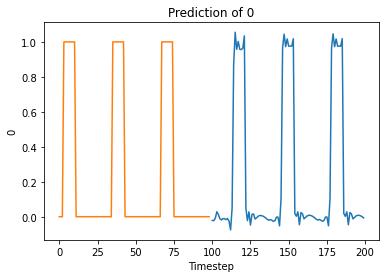

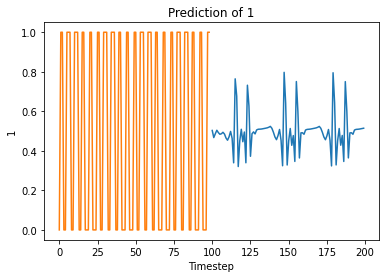

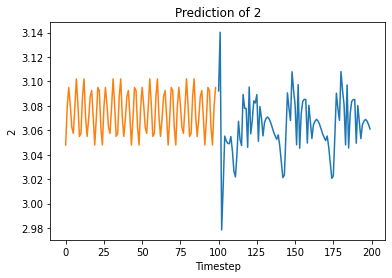

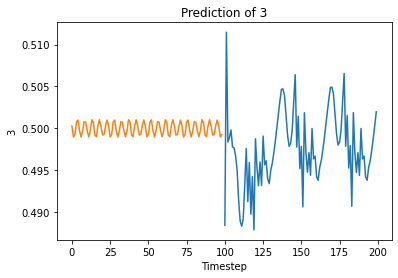

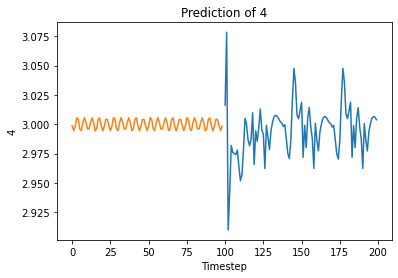

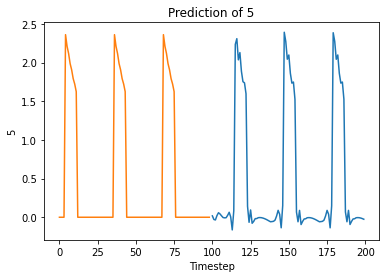

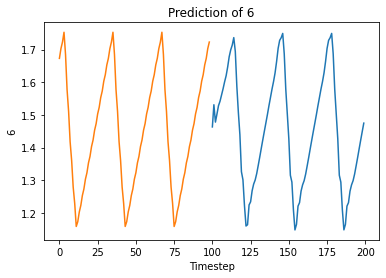

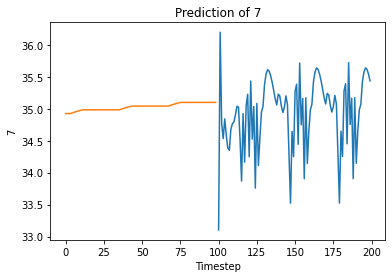

In [49]:
attr = len(inv_yhat.T)
for i in range(attr):
    title = "Prediction of "+str(i)
    actual = raw_data[9901:10000,i]
    pred = inv_yhat.T
    pred_df = pd.DataFrame(inv_yhat)
    # specify the range based on the length of predicted output
    index = pd.Index(list(range(100,200)))
    pred_df = pred_df.set_index(index)
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel(i)
#     plt.plot(pred[i], label="predicted")
#     plt.plot(actual, label="actual")
    plt.plot(pred_df[i])
    plt.plot(actual)
    plt.show()

In [1]:
print("Welcome , H.B Adeyemo")

Welcome , H.B Adeyemo


### Forecasting fewer outputs with Enc-Dec GRU

### Fault Injection

In [ ]:
## Fault Injection
from pandas import read_csv
from random import randint
# from random import random
import random
import math


def inject_Fault_Univariate(data):
    n = len(data)
    fault_units = [-30.5, -20.5, 0, 15.5, 25.5]
    for i in range(len(data)):
        p = random.random()
        if p > 0.5:
            data["column"].iloc[i] += random.choice(fault_units)
            
    return data

def inject_Fault_Multivariate(data):
    n = len(data)
    fault_units = [-30.5, -20.5, 0, 15.5, 25.5]
    for col in data.columns:
        
        for i in range(len(data)):
            p = random.random()
            if p > 0.5:
                data[col].iloc[i] += random.choice(fault_units)

    return data

def bit_flip(data, col, loc):
    if (len(data[col].unique())):
        for i in data[col]:
            data[col][i] = random.randint(0,1)
    return data

def insert_outlier(data, col):
#     // This inserts at the beginning of the data
    maxi = data.describe()[col]["max"]
    mini = data.describe()[col]["min"]
    outlier = (maxi - mini)*50
    n = math.floor(len(data)*0.2)
    for i in range(len(data[col][0:n])):
        data[col].iloc[i] += outlier    
    return data

def stuck_at(data, val, col, loc="beg"):
    # This is either stuck_at zero or at 1
    if(loc == "beg"):
        n = math.floor(len(data[col])*0.3)
        for i in range(n):
            data[col][i] = val
    return data



my_data = read_csv("waterTank.csv", header=0)
my_data = my_data.iloc[1:50,:]

# myNewdata = inject_Fault_Univariate(my_data)
myNewdata = inject_Fault_Multivariate(my_data)
myNewdata.to_csv("Randomized_data.csv")

flipped_data = bit_flip(my_data, "Tank1InFlow")
flipped_data.to_csv("flipped_data.csv")

outliered = insert_outlier(my_data, "Tank2WaterLevel")
outliered.to_csv("outlier_data.csv")

stuck_data = stuck_at(my_data, 1, "Tank1InFlow", loc="beg")
stuck_data.to_csv("stuck_at_one.csv")

print("Files saved successfully")

In [76]:
import pandas as pd
from numpy import array
from pandas import read_csv
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np


def value_flip(data, loc, col):
    for dp in data.index[loc]:
        if(data[col][dp] == 1):
            data[col][dp] = 0
        else:
            data[col][dp] = 1
#         if(dp == 1):
#             data.iloc[dp,col] = 0
#         else:
#             data.iloc[dp,col] = 1
#         data.iloc[dp,col] = 4
            
    return data


# mydata = read_csv('simulated_waterTank.csv', header=0, index_col=0, skiprows=4)
mydata = read_csv('waterTankNew.csv', header=0, index_col=0)
faulty_data = value_flip(mydata, range(100), "Tank1InFlow")
faulty_data
# mydata


C:\Users\user\AppData\Local\Temp\ipykernel_22720\1553794209.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col][dp] = 1
C:\Users\user\AppData\Local\Temp\ipykernel_22720\1553794209.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col][dp] = 0


,wt3_valve,Tank1InFlow,Tank1WaterLevel,Tank2OutFlow,Tank2WaterLevel,Tank3OutFlow,Tank2.level,Tank2_puddle
time,,,,,,,,
0,0,1,1.000000e-06,0.000000,0.000000e+00,0.0,0.000000,0.022568
1,0,1,6.890000e-07,0.000000,3.110000e-07,0.0,0.000000,0.022568
2,0,0,3.333928e-03,0.000000,4.050000e-07,0.0,0.000000,0.022568
3,0,1,5.448433e-02,0.000000,8.850002e-03,0.0,0.000000,0.022568
4,0,0,7.717051e-02,0.000000,2.949715e-02,0.0,0.000000,0.022568
...,...,...,...,...,...,...,...,...
19996,0,1,3.078778e+00,0.498971,2.994546e+00,0.0,1.233318,50.073060
19997,0,1,3.095068e+00,0.499269,2.998294e+00,0.0,1.253281,50.073060
19998,0,0,3.081061e+00,0.500793,3.005633e+00,0.0,1.283236,50.073060


In [65]:
# newList = [x for x in mydata.iloc[range(5),0]]
result = [x for x in mydata.iloc[range(5),0]]
print(result)

[4, 0, 0, 0, 0]
